# Data Access Methods

This tutorial demostrates several ways data can be accessed remotely and loaded into a Python environment, including

* THREDDS/OPeNDAP
* OGC Web Feature Service (WFS)
* direct access to files on cloud storage (AWS S3)
* cloud-optimised formats Zarr & Parquet
* New OGC APIs

## THREDDS / OPeNDAP  **TODO**

## Web Feature Service (WFS)

* A [standard](http://www.opengeospatial.org/standards/wfs) of the [Open Geospatial Consortium](http://www.opengeospatial.org/) (OGC)
* Allows geographic _features_ (spatial extent + data) to be accessed via the Web.
* Allows filtering based on spatial extent and attributes.

For example, most of the tabular (1-dimensional) data from the Australian Integrated Marine Observing System (IMOS) is available via WFS.

In [1]:
from owslib.wfs import WebFeatureService

wfs = WebFeatureService(url="https://geoserver-123.aodn.org.au/geoserver/wfs",
                        version="1.1.0")
wfs.identification.title

'AODN Web Feature Service (WFS)'

In [2]:
# Each dataset is served as a separate "feature type":
print(f"There are {len(wfs.contents)} fature types, e.g.")
list(wfs.contents)[:10]

There are 397 fature types, e.g.


['imos:anmn_ctd_profiles_data',
 'imos:anmn_ctd_profiles_map',
 'imos:anmn_velocity_timeseries_map',
 'imos:anmn_nrs_rt_meteo_timeseries_data',
 'imos:anmn_nrs_rt_meteo_timeseries_map',
 'imos:anmn_nrs_rt_bio_timeseries_data',
 'imos:anmn_nrs_rt_bio_timeseries_map',
 'imos:anmn_nrs_rt_wave_timeseries_data',
 'imos:anmn_nrs_rt_wave_timeseries_map',
 'imos:anmn_acoustics_map']

For now we'll assume we already know which featuretype we want. It's a dataset containing selected CTD profiles obtained at the National Reference Stations around australia.

In [3]:
typename = 'imos:nrs_depth_binned_ctd_data'
wfs.get_schema(typename)

{'properties': {'Project': 'string',
  'StationName': 'string',
  'TripCode': 'string',
  'CastTimeUTC': 'dateTime',
  'Latitude': 'decimal',
  'Longitude': 'decimal',
  'file_id': 'int',
  'SampleTime_Local': 'string',
  'SampleTime_UTC': 'dateTime',
  'trip_code': 'string',
  'SampleDepth_m': 'float',
  'Salinity_psu': 'float',
  'Salinity_flag': 'string',
  'Temperature_degC': 'float',
  'Temperature_flag': 'string',
  'DissolvedOxygen_umolkg': 'float',
  'DissolvedOxygen_flag': 'string',
  'Chla_mgm3': 'float',
  'Chla_flag': 'string',
  'Turbidity_NTU': 'float',
  'Turbidity_flag': 'string',
  'Conductivity_Sm': 'float',
  'Conductivity_flag': 'string',
  'WaterDensity_kgm3': 'float',
  'WaterDensity_flag': 'string'},
 'required': [],
 'geometry': 'Point',
 'geometry_column': 'geom'}

We can read in a subset of the data by specifying a bounding box (in this case near Rottnest Island, just off Perth, WA).

We'll get the result in CSV format so it's easy to read into a Pandas DataFrame.

In [4]:
import pandas as pd

xmin, xmax = 115.2, 115.7
ymin, ymax = -32.2, -31.8

response = wfs.getfeature(typename=typename, bbox=(xmin, ymin, xmax, ymax), outputFormat='csv')
df = pd.read_csv(response)
response.close()

df.head()

FID Project      StationName  \
0  nrs_depth_binned_ctd_data.fid-2a03b077_18971e1...     NRS  Rottnest Island   
1  nrs_depth_binned_ctd_data.fid-2a03b077_18971e1...     NRS  Rottnest Island   
2  nrs_depth_binned_ctd_data.fid-2a03b077_18971e1...     NRS  Rottnest Island   
3  nrs_depth_binned_ctd_data.fid-2a03b077_18971e1...     NRS  Rottnest Island   
4  nrs_depth_binned_ctd_data.fid-2a03b077_18971e1...     NRS  Rottnest Island   

      TripCode          CastTimeUTC  Latitude  Longitude  file_id  \
0  ROT20100520  2010-05-20T02:06:34       -32   115.4167     2561   
1  ROT20100520  2010-05-20T02:06:34       -32   115.4167     2561   
2  ROT20100520  2010-05-20T02:06:34       -32   115.4167     2561   
3  ROT20100520  2010-05-20T02:06:34       -32   115.4167     2561   
4  ROT20100520  2010-05-20T02:06:34       -32   115.4167     2561   

      SampleTime_Local       SampleTime_UTC  ... DissolvedOxygen_umolkg  \
0  2010-05-20 10:05:00  2010-05-20T02:05:00  ...                    NaN   
1  2010-05-20 10:05:00  2010-05-20T02:05:00  ...                    NaN   
2  2010-05-20 10:05:00  2010-05-20T02:05:00  ...                    NaN   
3  2010-05-20 10:05:00  2010-05-20T02:05:00  ...                    NaN   
4  2010-05-20 10:05:00  2010-05-20T02:05:00  ...                    NaN   

  DissolvedOxygen_flag  Chla_mgm3  Chla_flag  Turbidity_NTU  Turbidity_flag  \
0                  NaN     0.3787        0.0         0.0751             0.0   
1                  NaN     0.4106        0.0         0.0765             0.0   
2                  NaN     0.4201        0.0         0.0799             0.0   
3                  NaN     0.4490        0.0         0.0847             0.0   
4                  NaN     0.5021        0.0         0.0790             0.0   

   Conductivity_Sm  Conductivity_flag  WaterDensity_kgm3  WaterDensity_flag  
0           5.0086                  1          1024.9067                0.0  
1           5.0087                  1          1024.9117                0.0  
2           5.0086                  1          1024.9164                0.0  
3           5.0074                  1          1024.9200                0.0  
4           5.0065                  1          1024.9272                0.0  

[5 rows x 27 columns]

We can also filter the data based on the values in specified columns (properties) and ask for only a subset of the columns to be returned. The filters need to be provided in XML format, but the `owslib` library allows us to construct them in a more Pythonic way.

In [5]:
from owslib.etree import etree
from owslib.fes import PropertyIsEqualTo, And

filter = And([PropertyIsEqualTo(propertyname="StationName", literal="Rottnest Island"),
              PropertyIsEqualTo(propertyname="Temperature_flag", literal="1"),
              PropertyIsEqualTo(propertyname="Salinity_flag", literal="1")
             ])
filterxml = etree.tostring(filter.toXML(), encoding="unicode")
response = wfs.getfeature(typename=typename, filter=filterxml, outputFormat="csv",
                          propertyname=["CastTimeUTC", "SampleDepth_m", "Temperature_degC", "Salinity_psu", "Chla_mgm3"]
                         )
df = pd.read_csv(response, parse_dates=["CastTimeUTC"])
response.close()

# df.set_index(["CastTimeUTC", "SampleDepth_m"], inplace=True)

# the server adds a feature ID column we don't really need
df.drop(columns='FID', inplace=True)

df

CastTimeUTC  SampleDepth_m  Salinity_psu  Temperature_degC  \
0    2010-05-20 02:06:34              2       35.6492           21.3280   
1    2010-05-20 02:06:34              3       35.6495           21.3277   
2    2010-05-20 02:06:34              4       35.6495           21.3270   
3    2010-05-20 02:06:34              5       35.6463           21.3190   
4    2010-05-20 02:06:34              6       35.6468           21.3093   
...                  ...            ...           ...               ...   
6001 2023-06-13 01:36:01             42       35.2102           20.6584   
6002 2023-06-13 01:36:01             43       35.2102           20.6608   
6003 2023-06-13 01:36:01             44       35.2102           20.6614   
6004 2023-06-13 01:36:01             45       35.2101           20.6616   
6005 2023-06-13 01:36:01             46       35.2102           20.6619   

      Chla_mgm3  
0        0.3787  
1        0.4106  
2        0.4201  
3        0.4490  
4        0.5021  
...         ...  
6001     0.0330  
6002     0.0309  
6003     0.0321  
6004     0.0306  
6005     0.0329  

[6006 rows x 5 columns]

In [6]:
import holoviews
import hvplot.pandas

df.hvplot(x="Temperature_degC", y="SampleDepth_m", by="CastTimeUTC", flip_yaxis=True, legend=False, width=1200, height=500)

:NdOverlay   [CastTimeUTC]
   :Curve   [Temperature_degC]   (SampleDepth_m)

In [7]:
df.hvplot.scatter(x="Salinity_psu", y="Temperature_degC",
                  xlim=(34, 37), ylim=(15, 25),
                  legend=False, width=700, height=700)

:Scatter   [Salinity_psu]   (Temperature_degC)

Further examples?
* Plot timeseries of near-surface values
* Complute MLD (or read from `nrs_derived_indices_data`) and plot timeseries
* Calculate average profile per month of year?
* Plot timeseries of various phytoplankton species abundances?

**TODO** Add abstract & metadata link to the example WFS layer

## Reading files on cloud storage

Data files made available to the public on cloud storage such as Amazon S3 can be accessed over the web as if they were stored locally. You just need to find the exact URL for each file.

For example, all the public data files hosted by the Australian Ocean Data Network are stored in an [S3 bucket](https://www.techtarget.com/searchaws/definition/AWS-bucket) called `imos-data`. You can browse the contents of the bucket and download individual files [here](https://imos-data.aodn.org.au). 

To access the bucket using Python, we'll use the `s3fs` library.

In [8]:
import s3fs

s3 = s3fs.S3FileSystem(anon=True)

# Let's take a look at what satellite SST products are available
sst_files = s3.ls("imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023")
sst_files[-20:]

['imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20230629120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20230630120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20230701120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20230702120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20230703120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20230704120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20230705120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/20230706120000-ABOM-L4_GHRSST-SSTfnd-RAMSSA_09km-AUS-v02.0-fv01.0.nc',
 'imos-data/IMOS/SRS/SST/ghrsst/L4/RAMSSA/2023/202307071

In [9]:
import xarray as xr
import holoviews as hv
import hvplot.xarray

ds = xr.open_dataset(s3.open(sst_files[-1]))  # Q: Should we use s3fs.S3Map() here instead of s3.open()?
ds

<xarray.Dataset>
Dimensions:           (time: 1, lat: 1081, lon: 1561)
Coordinates:
  * time              (time) datetime64[ns] 2023-07-18T12:00:00
  * lat               (lat) float32 -70.0 -69.92 -69.83 ... 19.83 19.92 20.0
  * lon               (lon) float32 60.0 60.08 60.17 60.25 ... 189.8 189.9 190.0
Data variables:
    sea_ice_fraction  (time, lat, lon) float32 ...
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    crs               int32 ...
Attributes: (12/65)
    id:                         RAMSSA_09km-ABOM-L4-AUS-v01
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    title:                      RAMSSA v1.1 Analysed high resolution foundati...
    summary:                    AMSR2-JAXA nobs=****** obsesd: avg=0.693 min=...
    source:                     AMSR2-JAXA,AVHRRMTB_G-NAVO,VIIRS_NPP_OSPO,VII...
    references:                 Beggs H., A. Zhong, G. Warren, O. Alves, G. B...
    ...                         ...
    geospatial_lat_max:         20.0
    geospatial_lat_min:         -70.0
    geospatial_lon_max:         190.0
    geospatial_lon_min:         60.0
    geospatial_bounds:          POLYGON((-70 60, 20 60, 20 190, -70 190, -70 ...
    geospatial_bounds_crs:      EPSG:4326

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
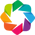

In [11]:
import geoviews as gv
import geoviews.feature as gf
from geoviews import opts
from cartopy import crs

gv.extension('bokeh', 'matplotlib')
gv.output(size=150)

In [13]:
sst_var = 'analysed_sst'
gds = gv.Dataset(ds,
                 kdims=['lon', 'lat'],
                 vdims=[sst_var],
                 crs=crs.PlateCarree(central_longitude=180)  # this is neede to properly handle lat > 180
                )
sst_plot = gds.to(gv.Image)
sst_plot.opts(cmap='coolwarm', colorbar=True, width=600, height=500, title=ds.title)

:Image   [lon,lat]   (analysed_sst)

It's worth understanding a little about how this works. 
The above example only reads the metadata and _a subset_ of the data, the entire file is read from S3 and returned. This is because unlike a local filesytem, the basic read/write operations on this kind of cloud storage (also called "object store") operate on the entire file (object). 
If you only need a small subset of a large file, this can be a very inefficient way to get it.

For example, if we wanted to plot a timeseries of the above satellite SST product at a given point, we would only need a single value out of each file (corresponding to one point in the timeseries), but the entire file would need to be read each time.

Let's try plotting the last 30 days of data for a point East of Tasmania...

In [ ]:
%%time
s3_objs = [s3.open(f) for f in sst_files[-30:]]
mds = xr.open_mfdataset(s3_objs)
mds

In [ ]:
mds[sst_var].sel(lat=-42, lon=150, method="nearest").hvplot()

### Zarr - a cloud-optimised data format



### Parquet?

## New OGC APIs?

# TODO

- [ ] Add metadata links for datasets used
